# Transit MCMC for Potential Exoplanet (TESS)

## Import Libraries

In [1]:
import numpy as np
from astropy.io import ascii
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams; rcParams["figure.dpi"] = 300
from astropy.table import Table, Column
from scipy.stats import norm
import math
import emcee
import batman
import corner

## Initial Transit Observations
- Import and extract TESS Data (tess2018206045859-s0001-0000000266980320-0120-s_lc.fits)
- Convert PDCSAP_FLUX to Normalized Flux and TIME to BJD$_{TDB}$
- Identify and take out NaN values
- Plot Transit Lightcurve

In [2]:
# Import tess2018206045859-s0001-0000000266980320-0120-s_lc.fits' fits file and extract the light curve data.
filename = 'tess2019357164649-s0020-0000000149833117-0165-s_lc.fits'
hdul = fits.open(filename)
hdul.info()
lctable = hdul[1].data
sapflux = lctable['SAP_FLUX']
pdcflux = lctable['PDCSAP_FLUX']
pdcerror = lctable['PDCSAP_FLUX_ERR']
quality = lctable['QUALITY']
time = lctable['TIME']

Filename: tess2019357164649-s0020-0000000149833117-0165-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18954R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


In [3]:
# Convert PDCSAP_FLUX to Normalized Flux and TIME to BJD_TDB
flux_median = np.nanmedian(pdcflux)
flux_median
rel_flux = pdcflux/flux_median
rel_flux_err = pdcerror/flux_median
time_jd = time + 2457000 

In [4]:
# Identify and take out NaNs
rel_flux_notnan = np.where(rel_flux==rel_flux)
rel_flux_new = rel_flux[rel_flux_notnan]
rel_flux_err_new = rel_flux_err[rel_flux_notnan]
time_new = time_jd[rel_flux_notnan]
quality_new = quality[rel_flux_notnan]

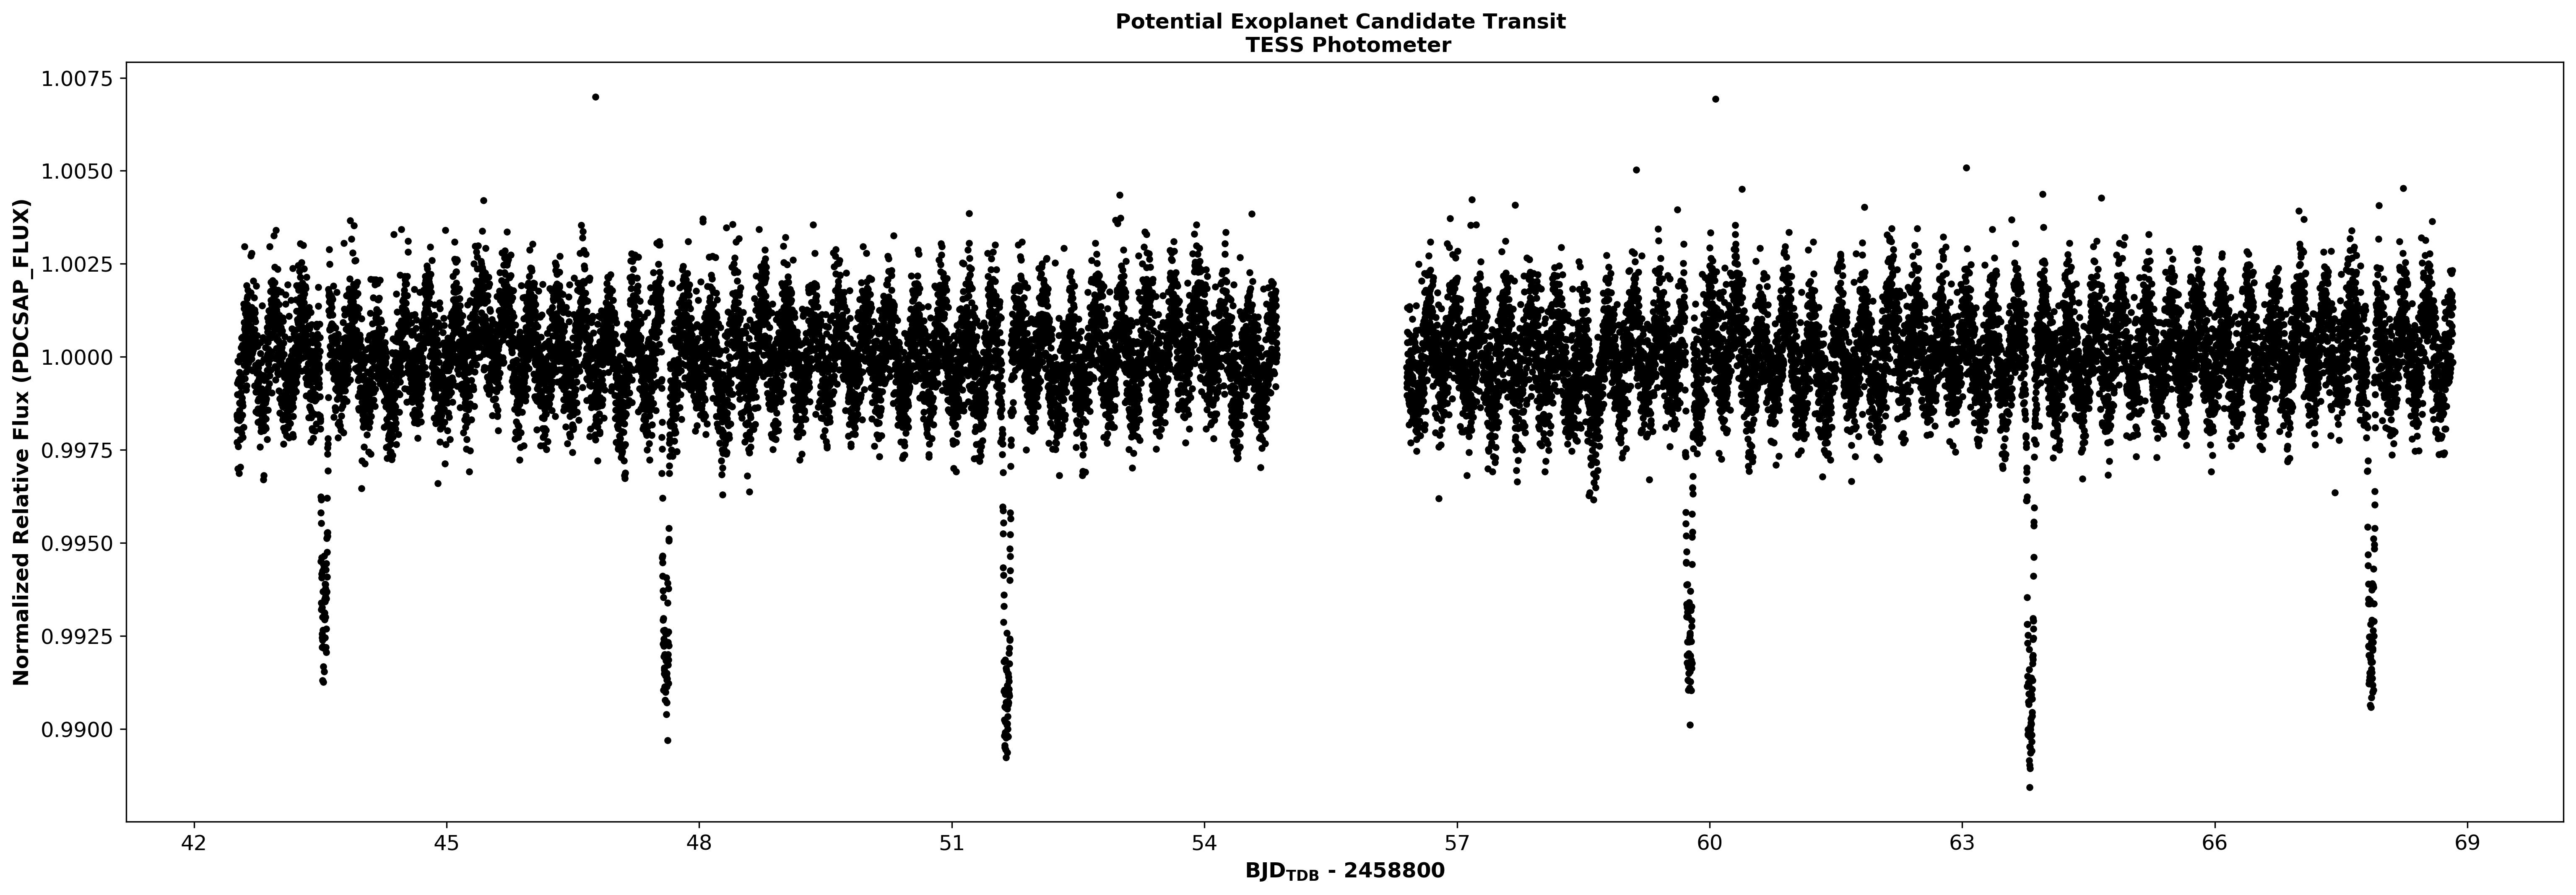

In [5]:
# Plot Transit Light Curve
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(time_new - 2458800, rel_flux_new, 'k.')
ax.set_xlabel(r'BJD$\mathregular{_{TDB}}$ - 2458800', fontsize='large', fontweight='bold')
ax.set_ylabel('Normalized Relative Flux (PDCSAP_FLUX)', fontsize='large', fontweight='bold')
ax.set_title('Potential Exoplanet Candidate Transit \n TESS Photometer', fontsize='large', fontweight='bold')
ax.xaxis.set_minor_locator(MaxNLocator())
ax.xaxis.set_major_locator(MaxNLocator())
#plt.xlim(43,44)
plt.show()


## BATMAN Transit Model
- Define Initial BATMAN Parameters for Transit
- Define BATMAN Transit Model Function
- Create Array for BATMAN Model Fluxes
- Plot Transit Light Curve with BATMAN Model Fluxes

In [14]:
# Define Initial BATMAN Parameters for Transit
pars = np.zeros(5)
pars[0] = 2458843.546               # Transit Center Time (t_0)
pars[1] = 88                        # Orbital Inclination (in degrees)                  
pars[2] = 0.09395                   # Planet Radius (in units of stellar radii)                    
pars[3] = 11.21                     # Semimajor Axis [a/rstar](in units of stellar radii)
pars[4] = 4.05                      # Orbital Period (days)

In [15]:
# Define BATMAN Transit Model Function
def transitmodel(pars, time):
    params = batman.TransitParams()
    params.t0 = pars[0]
    params.inc = pars[1]
    params.rp = pars[2]
    params.a = pars[3]
    params.per = pars[4]
    params.ecc = 0                       # Eccentricity
    params.w = 0                        # Longitude of Periastron (in degrees)                 
    params.limb_dark = "quadratic"       # Limb Darkening Model   
    params.u = [0.2986, 0.2354] # Limb Darkening Coefficients
    transitmod = batman.TransitModel(params, time)
    lc = transitmod.light_curve(params)
    return lc                     

In [16]:
# Create Array for BATMAN Model Fluxes
rel_flux_batman = transitmodel(pars,time_new) 

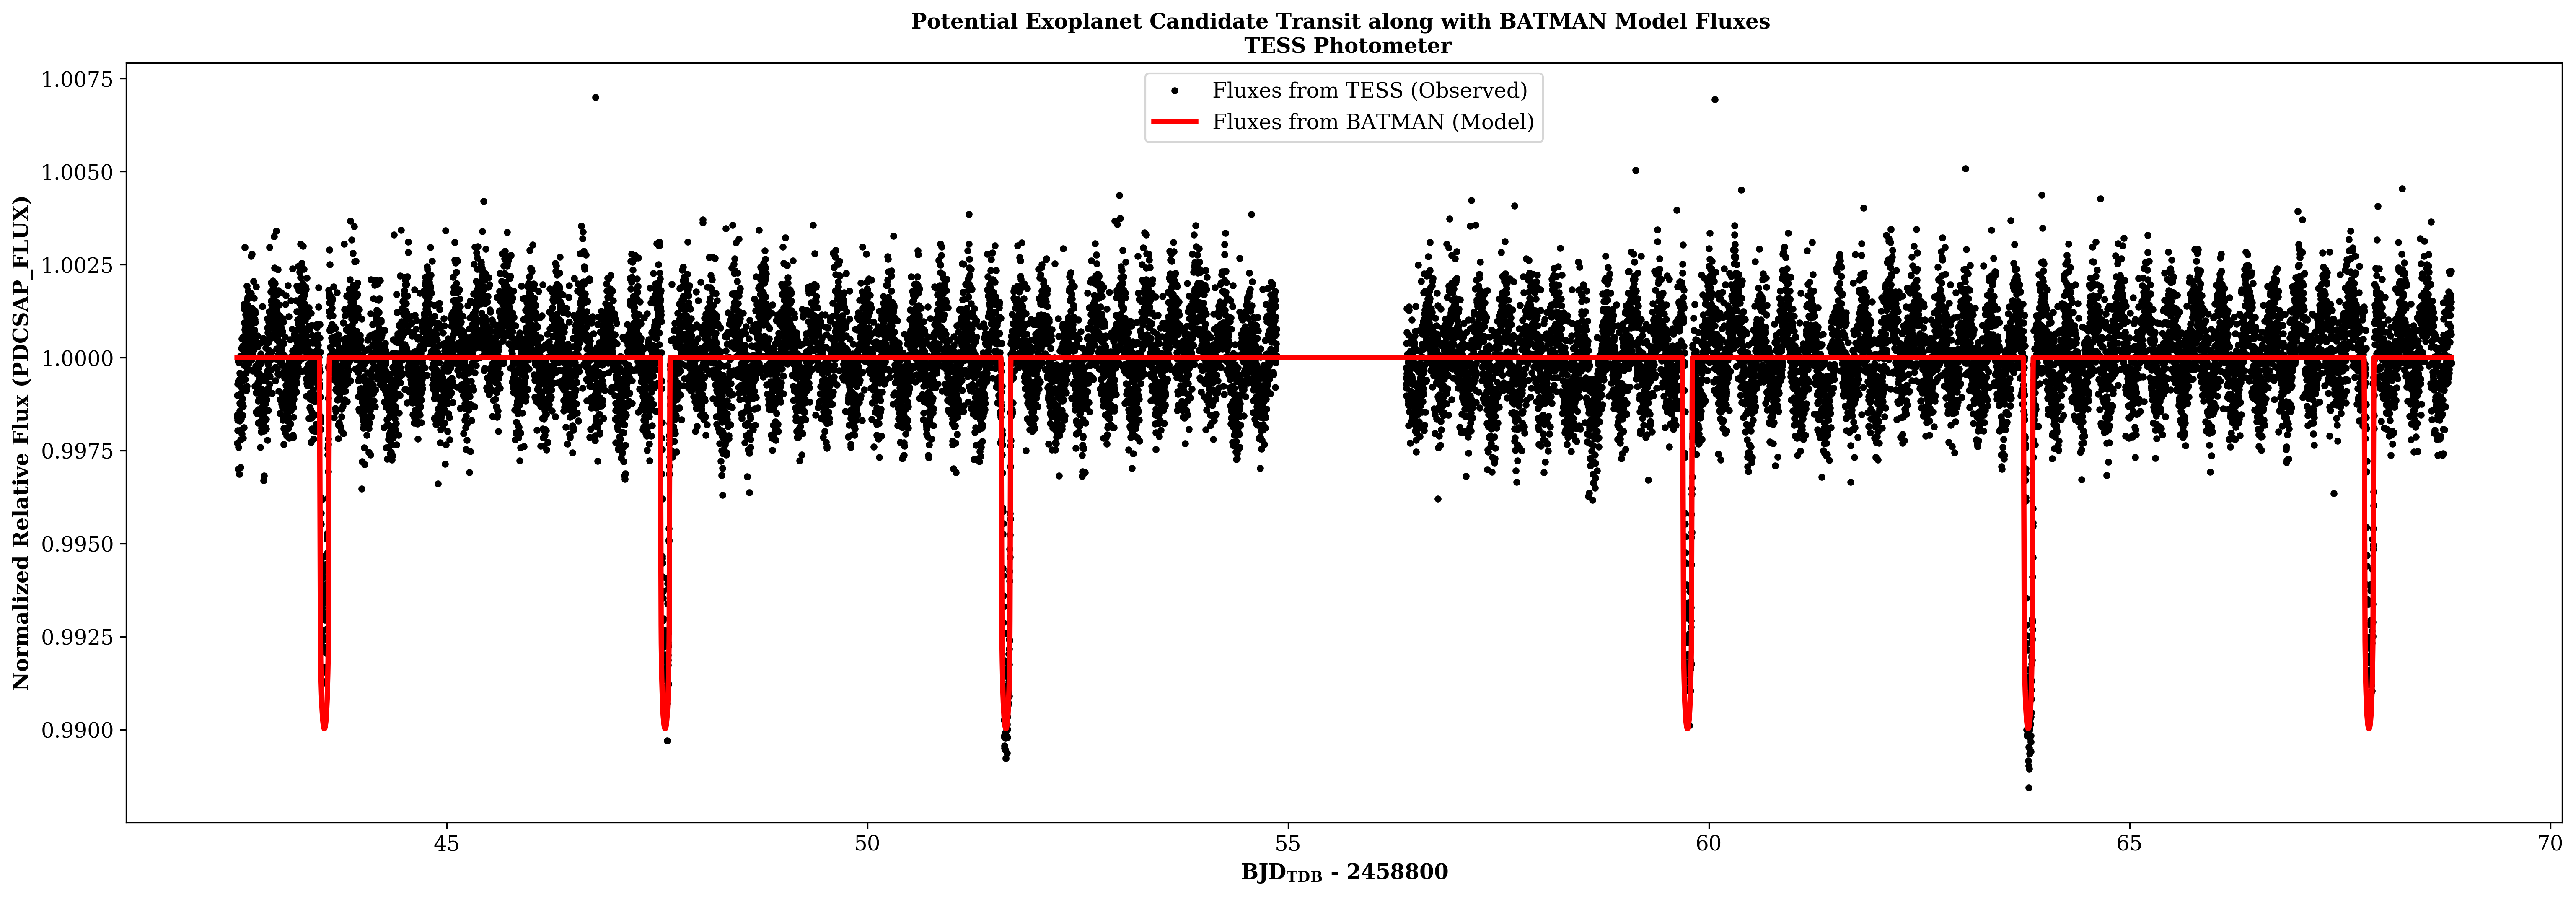

In [17]:
# Plot Transit Light Curve with BATMAN Model Fluxes
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
model = ax.plot(time_new - 2458800, rel_flux_batman, 'r-', zorder=1, lw=3)
tess = ax.plot(time_new - 2458800, rel_flux_new, 'k.', zorder=0)
ax.set_xlabel(r'BJD$\mathregular{_{TDB}}$ - 2458800', fontsize='large', fontweight='bold')
ax.set_ylabel('Normalized Relative Flux (PDCSAP_FLUX)', fontsize='large', fontweight='bold')
ax.set_title('Potential Exoplanet Candidate Transit along with BATMAN Model Fluxes \n TESS Photometer', fontsize='large', fontweight='bold')
ax.legend((tess[0],model[0]), ('Fluxes from TESS (Observed)', 'Fluxes from BATMAN (Model)'), loc='upper center', fontsize="large")
#plt.xlim(41,45)
#plt.savefig('batman_lightcurve_HATP20b.png', overwrite = True)
plt.show()

## MCMC on Transit Observations
- Define log_likelihood Function
- MCMC (Burn+Production) Runs
- sampler.chain.shape Plots - To Check Parameter Values for Each Walker
- sampler.flatchain.shape Plots - To Check Parameter Values for All Walkers (Walkers*Iterations)
- sampler.flatchain.shape Histograms - To Check Probability Distribution
- Median Value + Error for $t_0$
- Median Value + Error for $i$
- Median Value + Error for $R_p/R_{star}$
- Median Value + Error for $a/R_{star}$
- Median Value + Error for $P$

In [18]:
# Define log_likelihood Function 
def log_likelihood(pars, x, y, yerr):
    model =  transitmodel(pars,x)
    sigma = yerr
    lnprobmodel = -0.5 * np.sum(((y - model) ** 2. / sigma ** 2.) + np.log(2. * math.pi * sigma ** 2.))
    return lnprobmodel

In [19]:
log_likelihood(pars, time_new, rel_flux_new, rel_flux_err_new)

88898.5482320828

In [20]:
# MCMC (Burn+Production) Runs
nwalkers = 10
ndim = 5
scales = np.zeros(5)
scales[0] = 0.002           # Transit Center Time (t_0)
scales[1] = 1               # Orbital Inclination (in degrees)                  
scales[2] = 0.01            # Planet Radius (in units of stellar radii)                    
scales[3] = 0.1             # Semimajor Axis [a/rstar](in units of stellar radii)
scales[4] = 0.001           # Orbital Period (days)
pos = emcee.utils.sample_ball(pars, scales, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(time_new, rel_flux_new, rel_flux_err_new))
print("Running burn-in...")
pos,_,_ = sampler.run_mcmc(pos, 200, progress=True);
sampler.reset()
print("Running production...")
pos,_,_ = sampler.run_mcmc(pos, 2000, progress=True);
print(pos)

  2%|▏         | 4/200 [00:00<00:06, 32.21it/s]

Running burn-in...


  0%|          | 4/2000 [00:00<01:00, 32.89it/s]

Running production...


100%|██████████| 2000/2000 [01:00<00:00, 33.29it/s]

[[2.45884355e+06 8.47309430e+01 9.45012288e-02 8.82130983e+00
  4.05191609e+00]
 [2.45884355e+06 8.45607843e+01 9.44913219e-02 8.64697884e+00
  4.05210895e+00]
 [2.45884355e+06 8.47134747e+01 9.31850501e-02 8.75826310e+00
  4.05211382e+00]
 [2.45884355e+06 8.47609824e+01 9.39831706e-02 8.88216810e+00
  4.05214080e+00]
 [2.45884355e+06 8.45194292e+01 9.44361176e-02 8.59849058e+00
  4.05213329e+00]
 [2.45884355e+06 8.44412235e+01 9.49754249e-02 8.54233102e+00
  4.05198615e+00]
 [2.45884355e+06 8.47887740e+01 9.37204202e-02 8.88840019e+00
  4.05209866e+00]
 [2.45884355e+06 8.44627430e+01 9.42294449e-02 8.52142043e+00
  4.05209106e+00]
 [2.45884355e+06 8.47480636e+01 9.31866144e-02 8.81521929e+00
  4.05208913e+00]
 [2.45884355e+06 8.44375352e+01 9.48015951e-02 8.53870405e+00
  4.05208279e+00]]


/Users/astroarshn2000/anaconda3/envs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


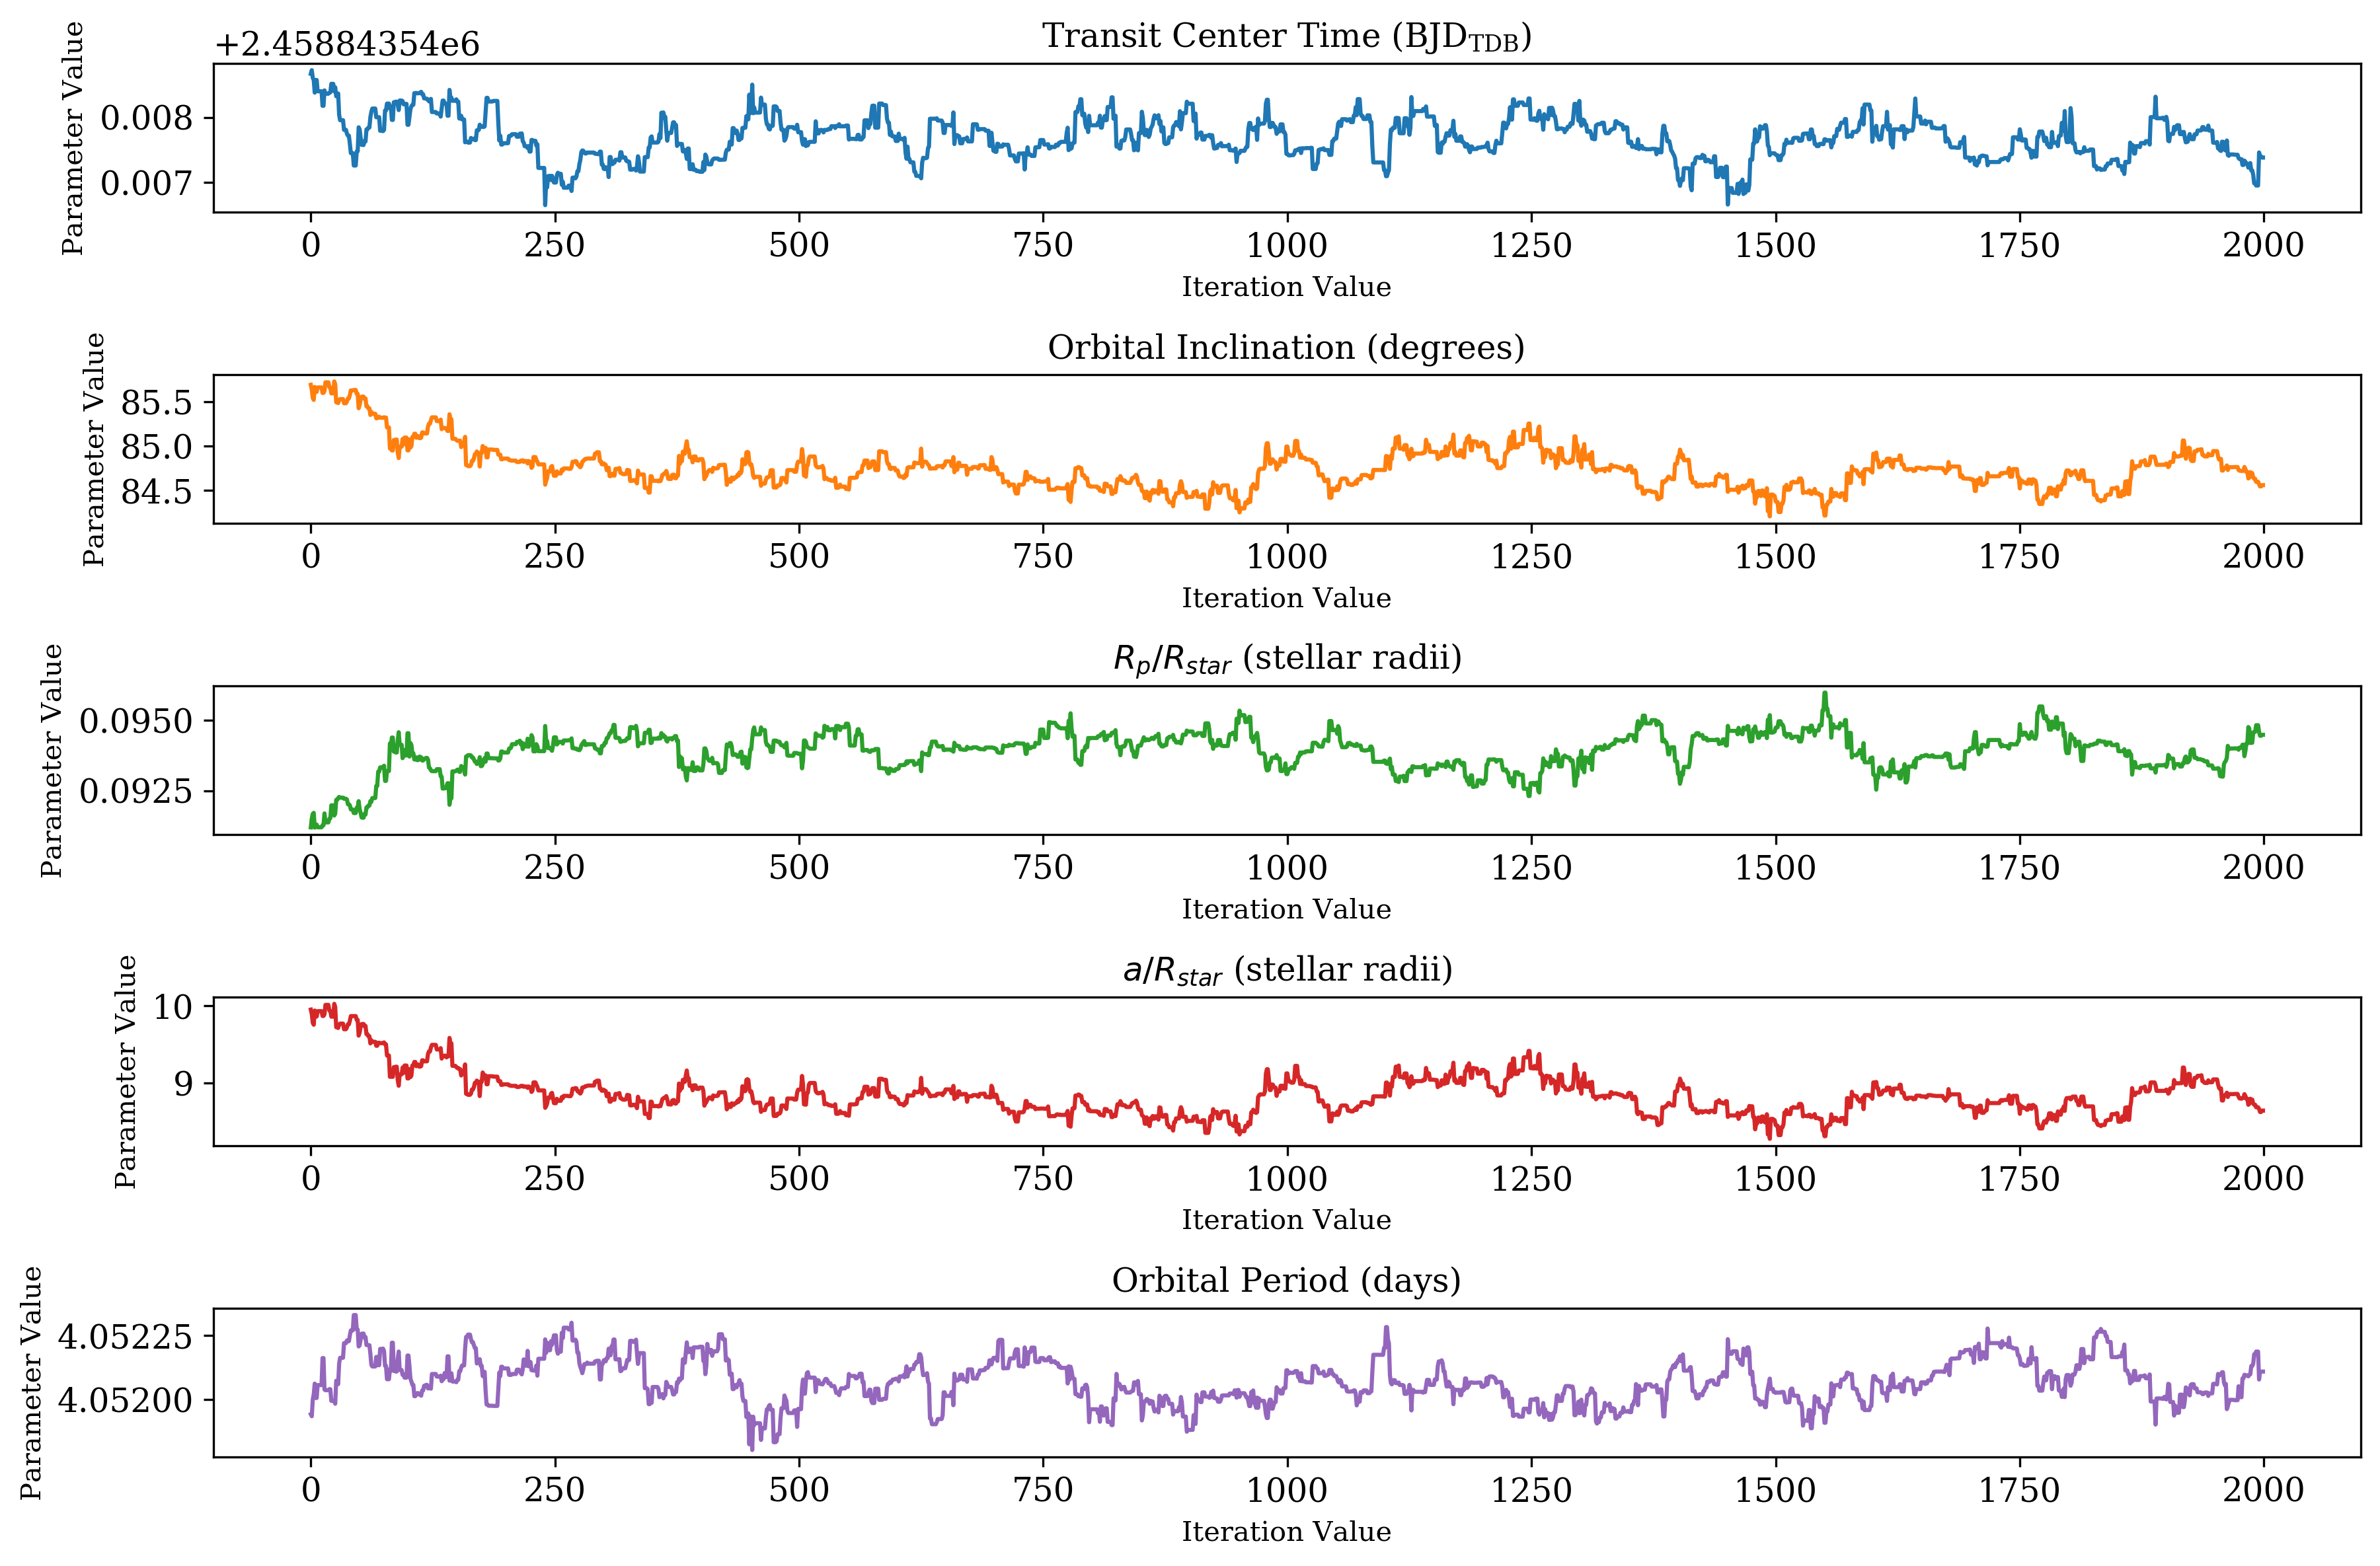

In [22]:
# sampler.chain.shape Plots - To Check Parameter Values for Each Walker
fig, axs = plt.subplots(5, figsize=(12,8))
axs[0].plot(sampler.chain[1,:,0])
axs[0].set_title('Transit Center Time (BJD$\mathregular{_{TDB}}$)')
axs[1].plot(sampler.chain[1,:,1], 'tab:orange')
axs[1].set_title('Orbital Inclination (degrees)')
axs[2].plot(sampler.chain[1,:,2], 'tab:green')
axs[2].set_title('$R_p/R_{star}$ (stellar radii)')
axs[3].plot(sampler.chain[1,:,3], 'tab:red')
axs[3].set_title('$a/R_{star}$ (stellar radii)')
axs[4].plot(sampler.chain[1,:,4], 'tab:purple')
axs[4].set_title('Orbital Period (days)')

for ax in axs.flat:
    ax.set(xlabel='Iteration Value', ylabel='Parameter Value')
fig.tight_layout()
fig.show()

/Users/astroarshn2000/anaconda3/envs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


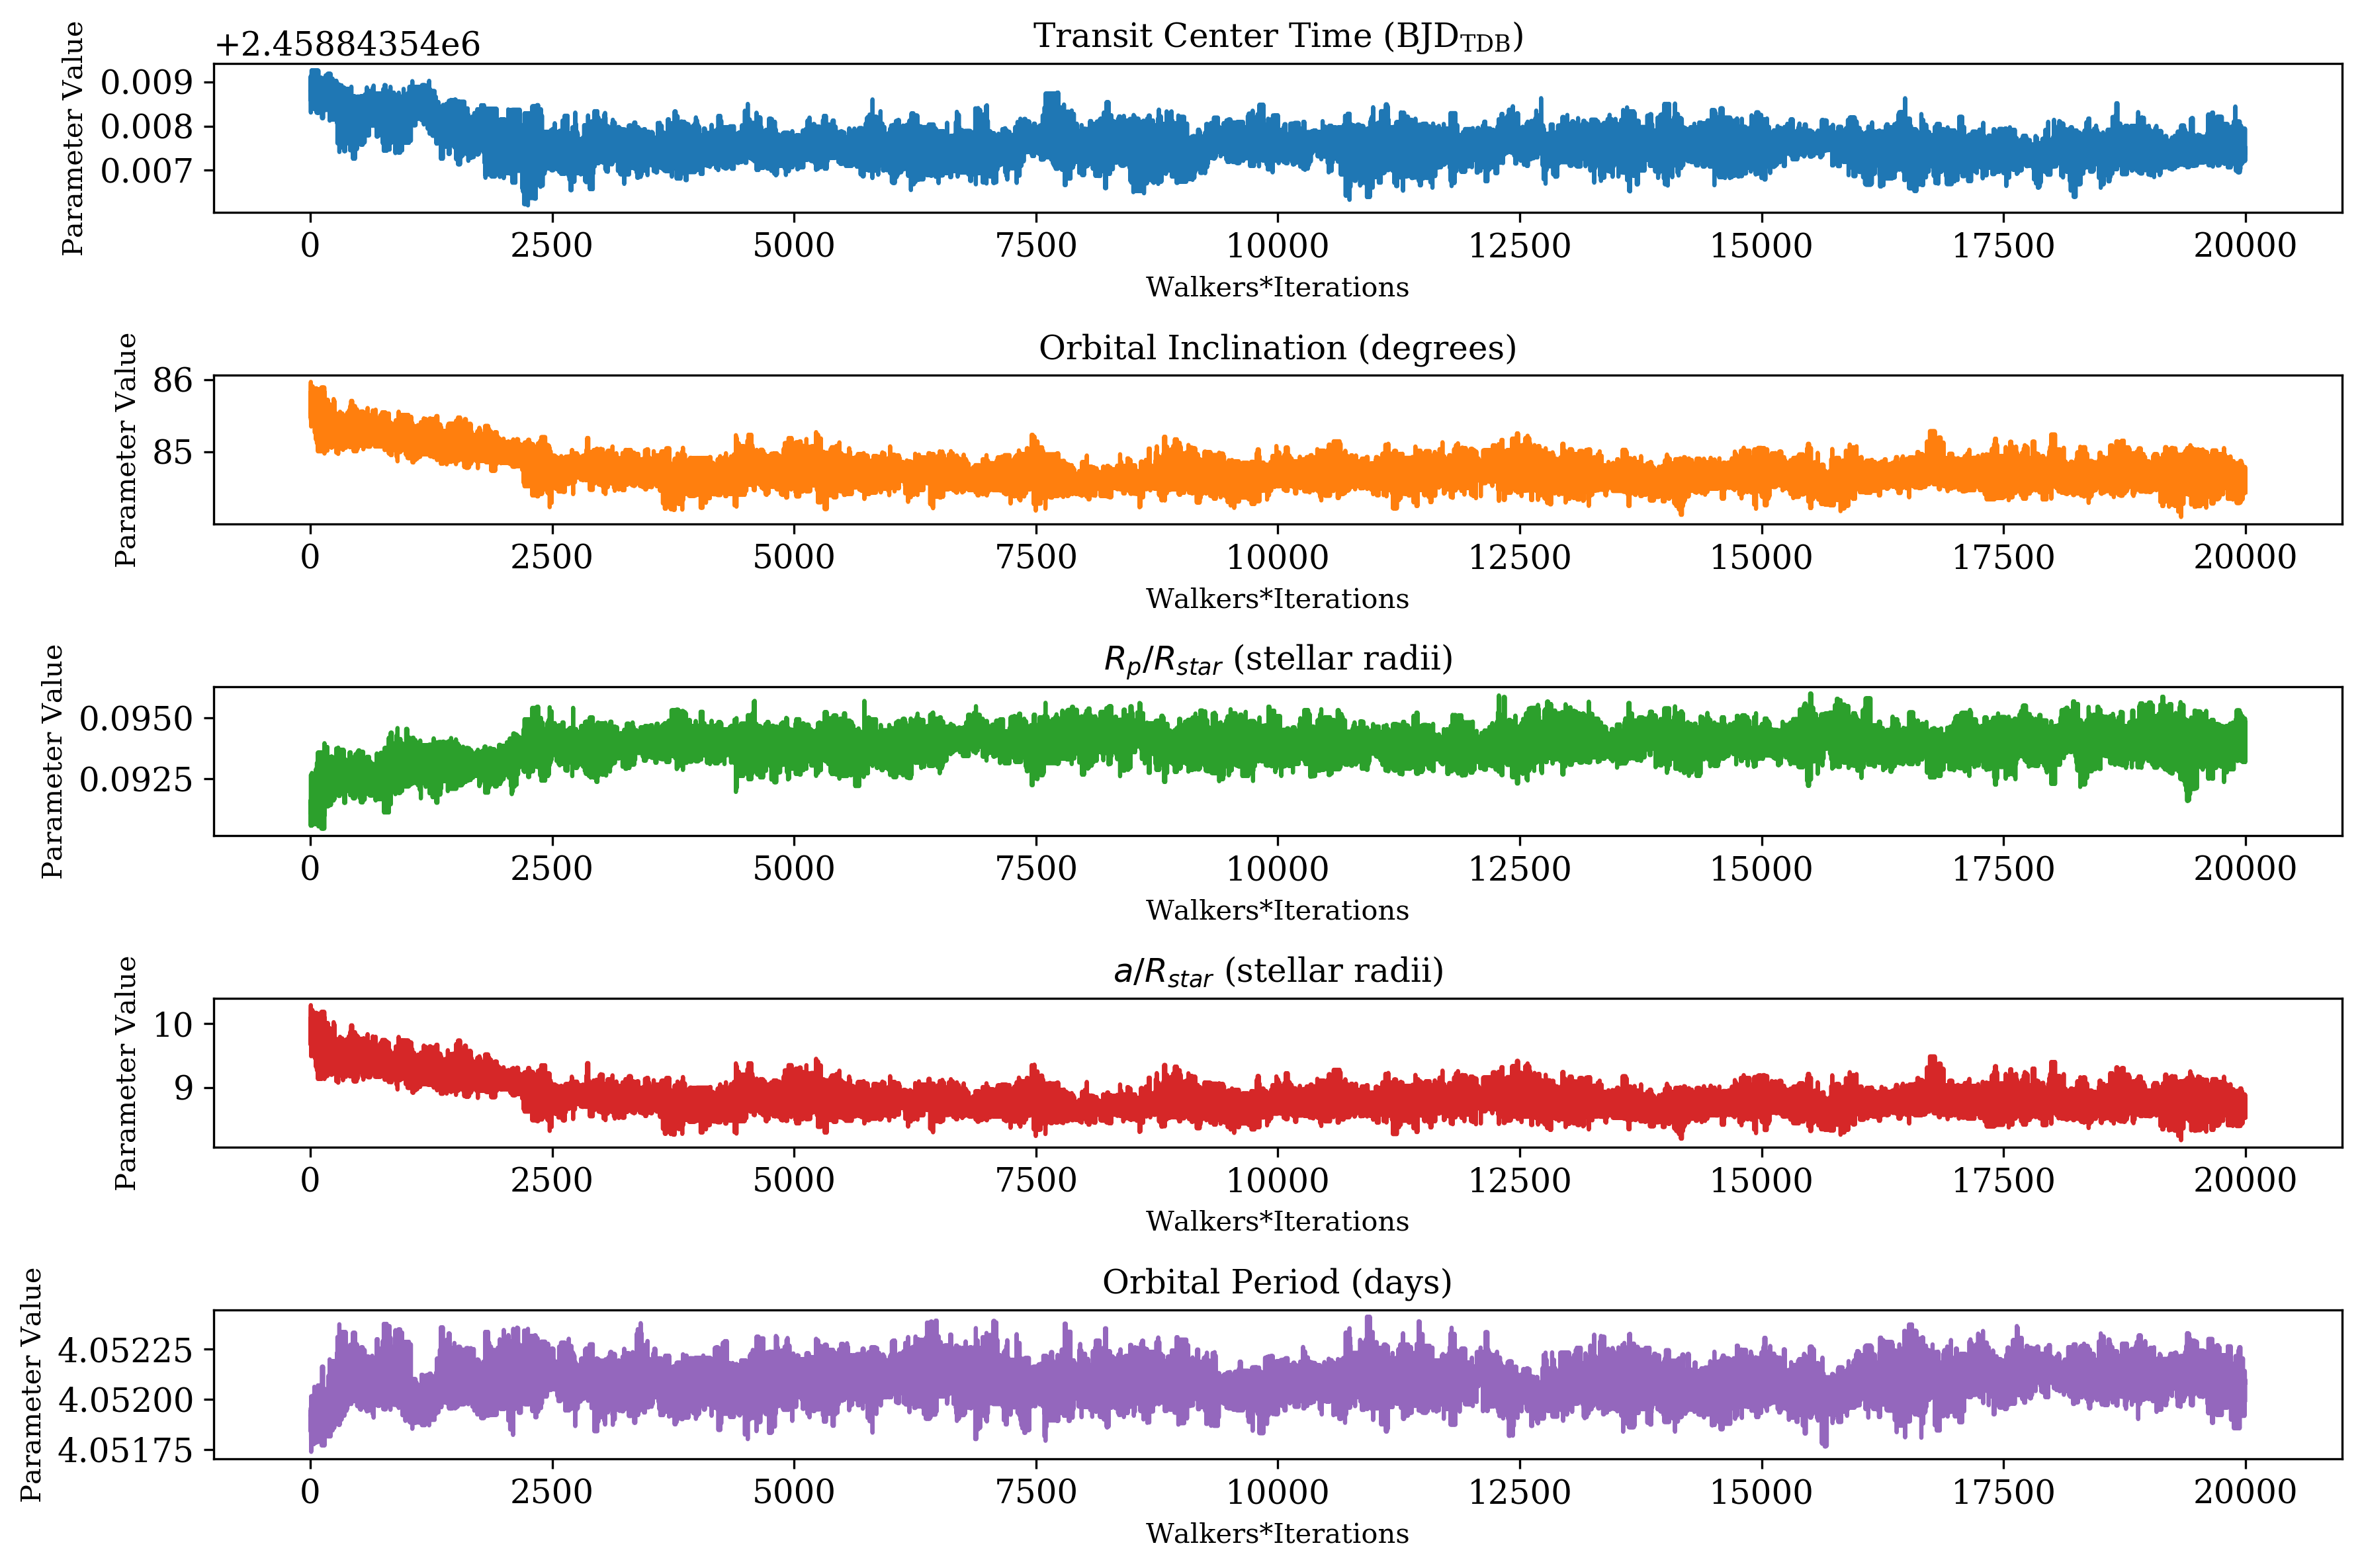

In [21]:
# sampler.flatchain.shape Plots - To Check Parameter Values for All Walkers (Walkers*Iterations)
fig, axs = plt.subplots(5, figsize=(12,8))
axs[0].plot(sampler.flatchain[:,0])
axs[0].set_title('Transit Center Time (BJD$\mathregular{_{TDB}}$)')
axs[1].plot(sampler.flatchain[:,1], 'tab:orange')
axs[1].set_title('Orbital Inclination (degrees)')
axs[2].plot(sampler.flatchain[:,2], 'tab:green')
axs[2].set_title('$R_p/R_{star}$ (stellar radii)')
axs[3].plot(sampler.flatchain[:,3], 'tab:red')
axs[3].set_title('$a/R_{star}$ (stellar radii)')
axs[4].plot(sampler.flatchain[:,4], 'tab:purple')
axs[4].set_title('Orbital Period (days)')

for ax in axs.flat:
    ax.set(xlabel='Walkers*Iterations', ylabel='Parameter Value')
fig.tight_layout()
fig.show()

/Users/astroarshn2000/anaconda3/envs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


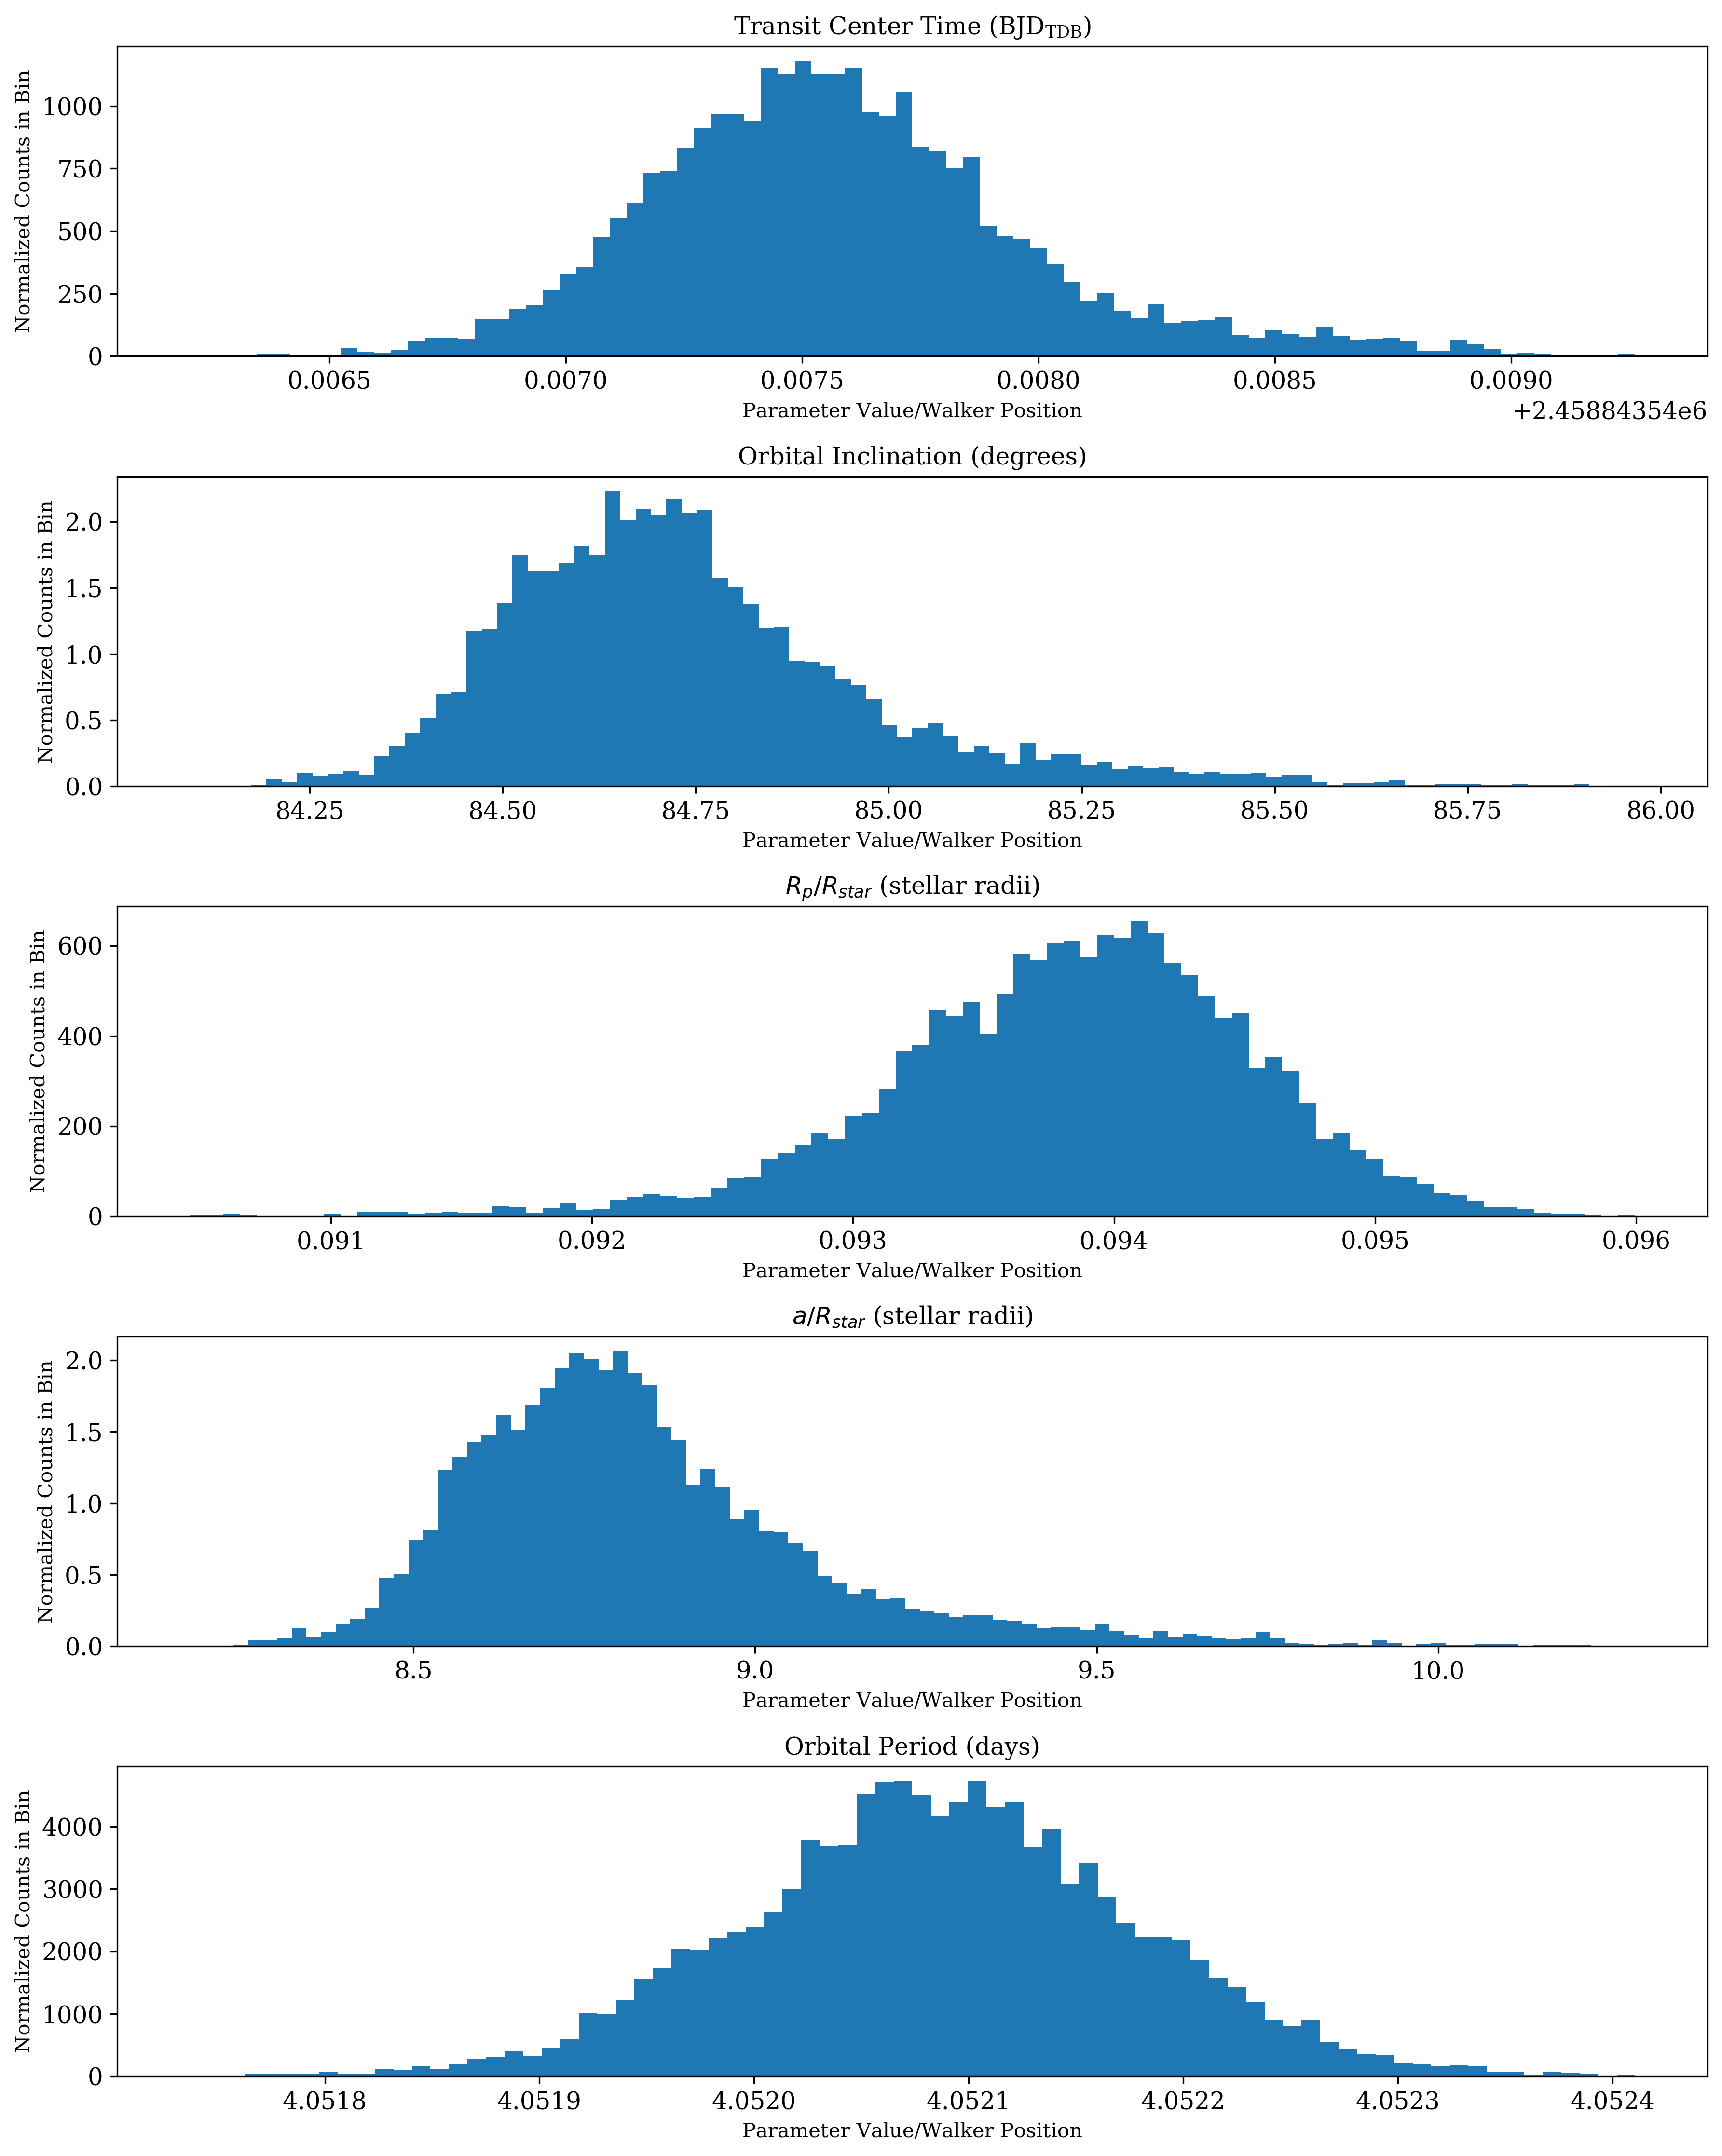

In [24]:
# sampler.flatchain.shape Histograms - To Check Probability Distribution
fig, axs = plt.subplots(5, figsize=(12,15))
axs[0].hist(sampler.flatchain[:,0], bins='auto', density = True)
axs[0].set_title('Transit Center Time (BJD$\mathregular{_{TDB}}$)')
axs[1].hist(sampler.flatchain[:,1], bins='auto', density = True)
axs[1].set_title('Orbital Inclination (degrees)')
axs[2].hist(sampler.flatchain[:,2], bins='auto', density = True)
axs[2].set_title('$R_p/R_{star}$ (stellar radii)')
axs[3].hist(sampler.flatchain[:,3], bins='auto', density = True)
axs[3].set_title('$a/R_{star}$ (stellar radii)')
axs[4].hist(sampler.flatchain[:,4], bins='auto', density = True)
axs[4].set_title('Orbital Period (days)')
for ax in axs.flat:
    ax.set(xlabel='Parameter Value/Walker Position', ylabel='Normalized Counts in Bin')
fig.tight_layout()
#plt.savefig('HD219666b_2D_sampler.flatchain_pdf.png', overwrite = True)
fig.show()

In [25]:
# Median Value + Error for t0
medval_t0 = np.median(sampler.flatchain[:,0])
minus_t0 = medval_t0 - np.percentile(sampler.flatchain[:,0],16.0)
plus_t0 = np.percentile(sampler.flatchain[:,0],84.0)- medval_t0
print(medval_t0)
print(minus_t0)
print(plus_t0)

2458843.547544838
0.0003424454480409622
0.0003843284212052822


In [26]:
# # Median Value + Error for i
medval_inc = np.median(sampler.flatchain[:,1])
minus_inc = medval_inc - np.percentile(sampler.flatchain[:,1],16.0)
plus_inc = np.percentile(sampler.flatchain[:,1],84.0)- medval_inc
print(medval_inc)
print(minus_inc)
print(plus_inc)

84.70466751992082
0.18133762478889537
0.2361889415509495


In [28]:
# Median Value + Error for Rp/Rstar
medval_rp = np.median(sampler.flatchain[:,2])
minus_rp = medval_rp - np.percentile(sampler.flatchain[:,2],16.0)
plus_rp = np.percentile(sampler.flatchain[:,2],84.0)- medval_rp
print(medval_rp)
print(minus_rp)
print(plus_rp)

0.09389007212235424
0.0006792675272860732
0.0006047430852448438


In [29]:
# # Median Value + Error for a/Rstar
medval_a = np.median(sampler.flatchain[:,3])
minus_a = medval_a - np.percentile(sampler.flatchain[:,3],16.0)
plus_a = np.percentile(sampler.flatchain[:,3],84.0)- medval_a
print(medval_a)
print(minus_a)
print(plus_a)

8.78997024637978
0.1913581659452941
0.2586238991602041


In [30]:
# Median Value + Error for P
medval_p = np.median(sampler.flatchain[:,4])
minus_p = medval_p - np.percentile(sampler.flatchain[:,4],16.0)
plus_p = np.percentile(sampler.flatchain[:,4],84.0)- medval_p
print(medval_p)
print(minus_p)
print(plus_p)

4.052085892927877
8.959579929168626e-05
9.070311584569168e-05


# Fitting Transit to Light Curve using MCMC Best-Fit Parameters
- Define Best-Fit Parameters from MCMC
- Define BATMAN Transit Model Fit Function
- Create Array for BATMAN Model Fit Fluxes
- Plot Best-Fit Light Curve
- Plot Corner-Plot

In [31]:
# Define Best-Fit Parameters from MCMC
pars_fit = np.zeros(5)
pars_fit[0] = medval_t0            # Transit Center Time (t_0)
pars_fit[1] = medval_inc           # Orbital Inclination (in degrees)                  
pars_fit[2] = medval_rp            # Planet Radius (in units of stellar radii)                    
pars_fit[3] = medval_a             # Semimajor Axis [a/rstar](in units of stellar radii)
pars_fit[4] = medval_p             # Orbital Period (in days)

In [32]:
# Define BATMAN Transit Model Fit Function
def transitmodel_fit(pars_fit, time):
    params = batman.TransitParams()
    params.t0 = pars_fit[0]
    params.inc = pars_fit[1]
    params.rp = pars_fit[2]
    params.a = pars_fit[3]
    params.per = pars_fit[4]
    params.ecc = 0                       # Eccentricity
    params.w = 0                         # Longitude of Periastron (in degrees)                 
    params.limb_dark = "quadratic"       # Limb Darkening Model   
    params.u = [0.2986, 0.2354] # Limb Darkening Coefficients
    transitmod = batman.TransitModel(params, time)
    lc_fit = transitmod.light_curve(params)
    return lc_fit

In [33]:
# Create Array for BATMAN Model Fluxes
rel_flux_fit = transitmodel_fit(pars_fit, time_new)

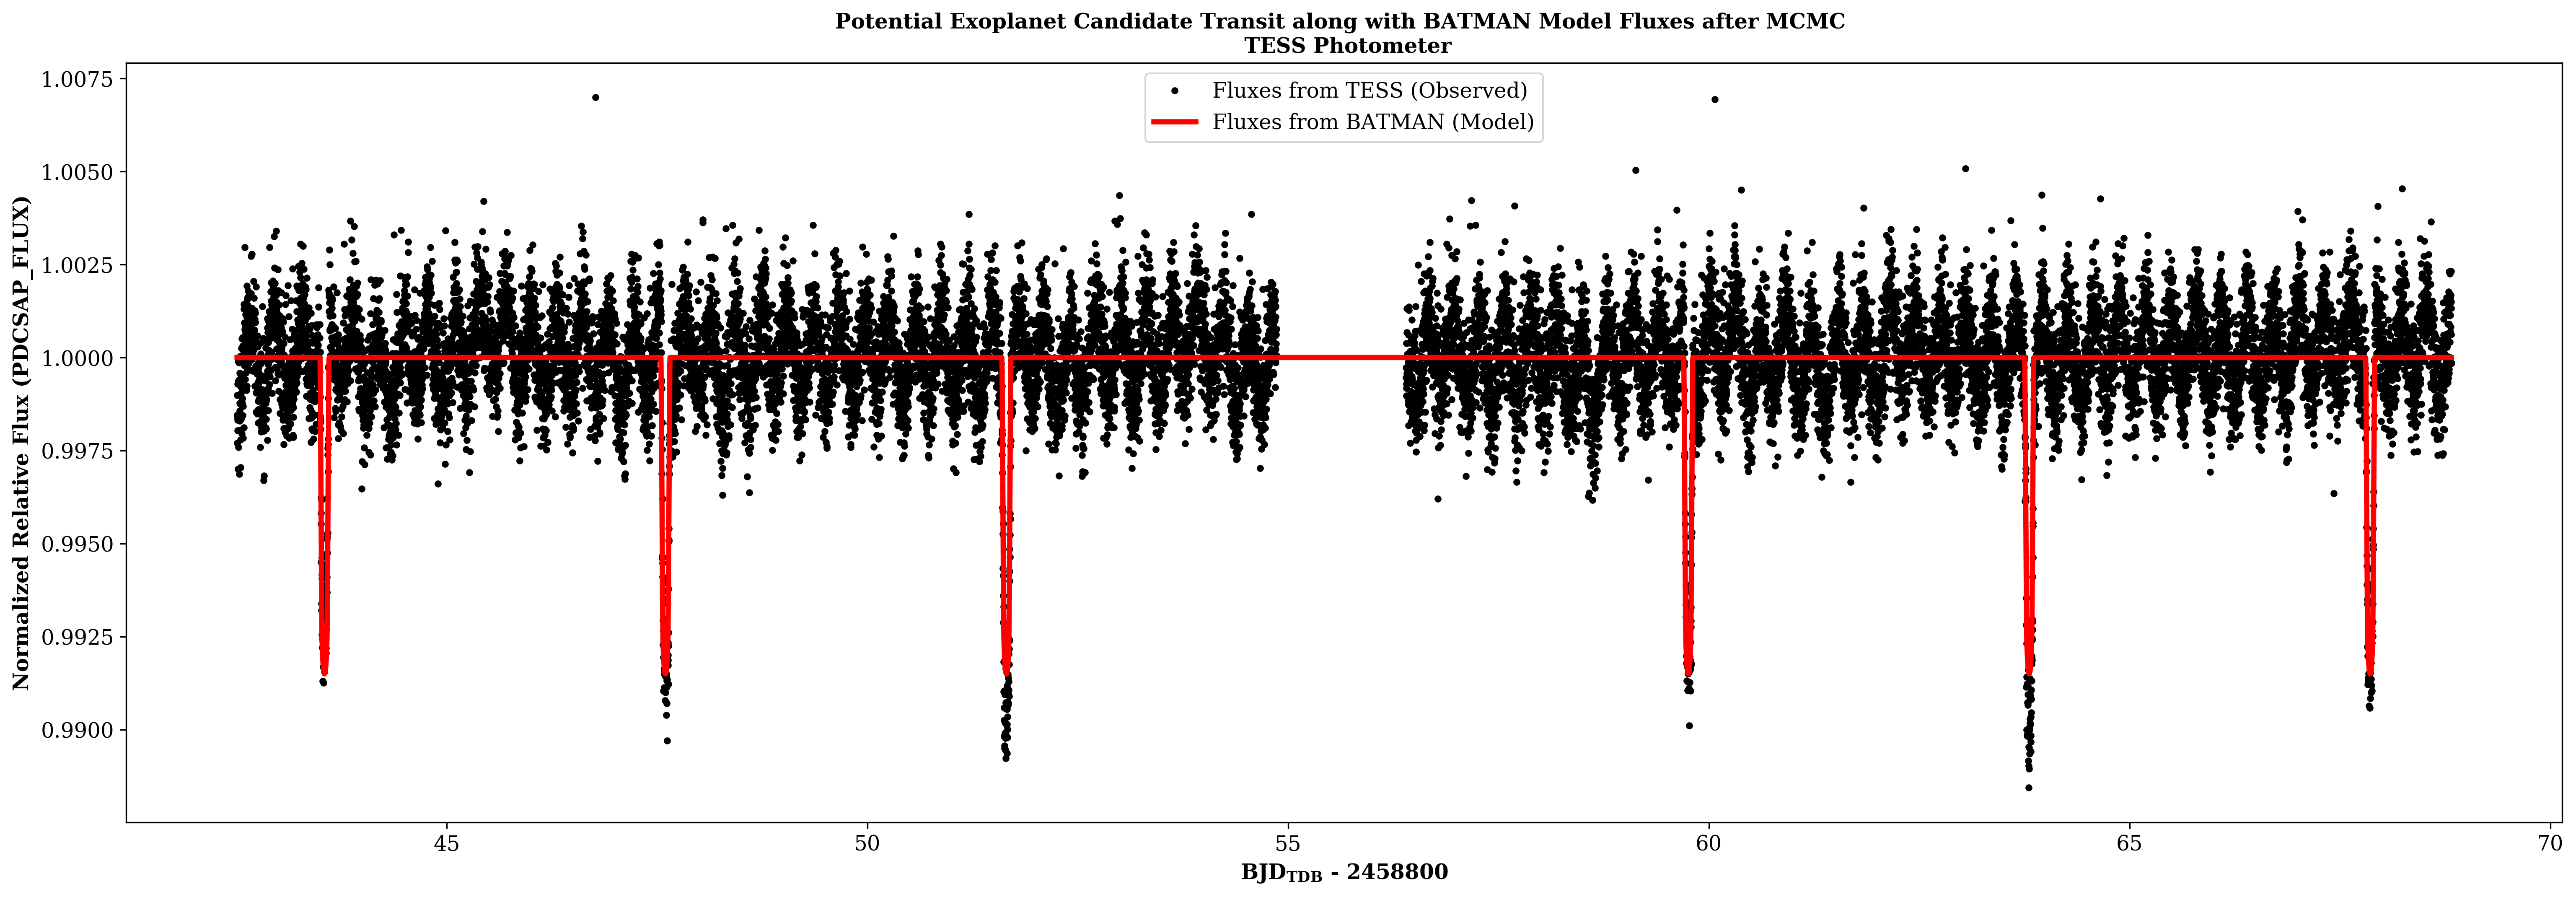

In [34]:
# Plot Best-Fit Light Curve
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
model_fit = ax.plot(time_new - 2458800, rel_flux_fit, 'r-', zorder=1, lw=3)
tess = ax.plot(time_new - 2458800, rel_flux_new, 'k.', zorder=0)
ax.set_xlabel(r'BJD$\mathregular{_{TDB}}$ - 2458800', fontsize='large', fontweight='bold')
ax.set_ylabel('Normalized Relative Flux (PDCSAP_FLUX)', fontsize='large', fontweight='bold')
ax.set_title('Potential Exoplanet Candidate Transit along with BATMAN Model Fluxes after MCMC \n TESS Photometer', fontsize='large', fontweight='bold')
ax.legend((tess[0],model_fit[0]), ('Fluxes from TESS (Observed)', 'Fluxes from BATMAN (Model)'), loc='upper center', fontsize="large")
#plt.xlim(51,53)
#plt.savefig('HD219666b_mcmc_fit.png', overwrite = True)
plt.show()

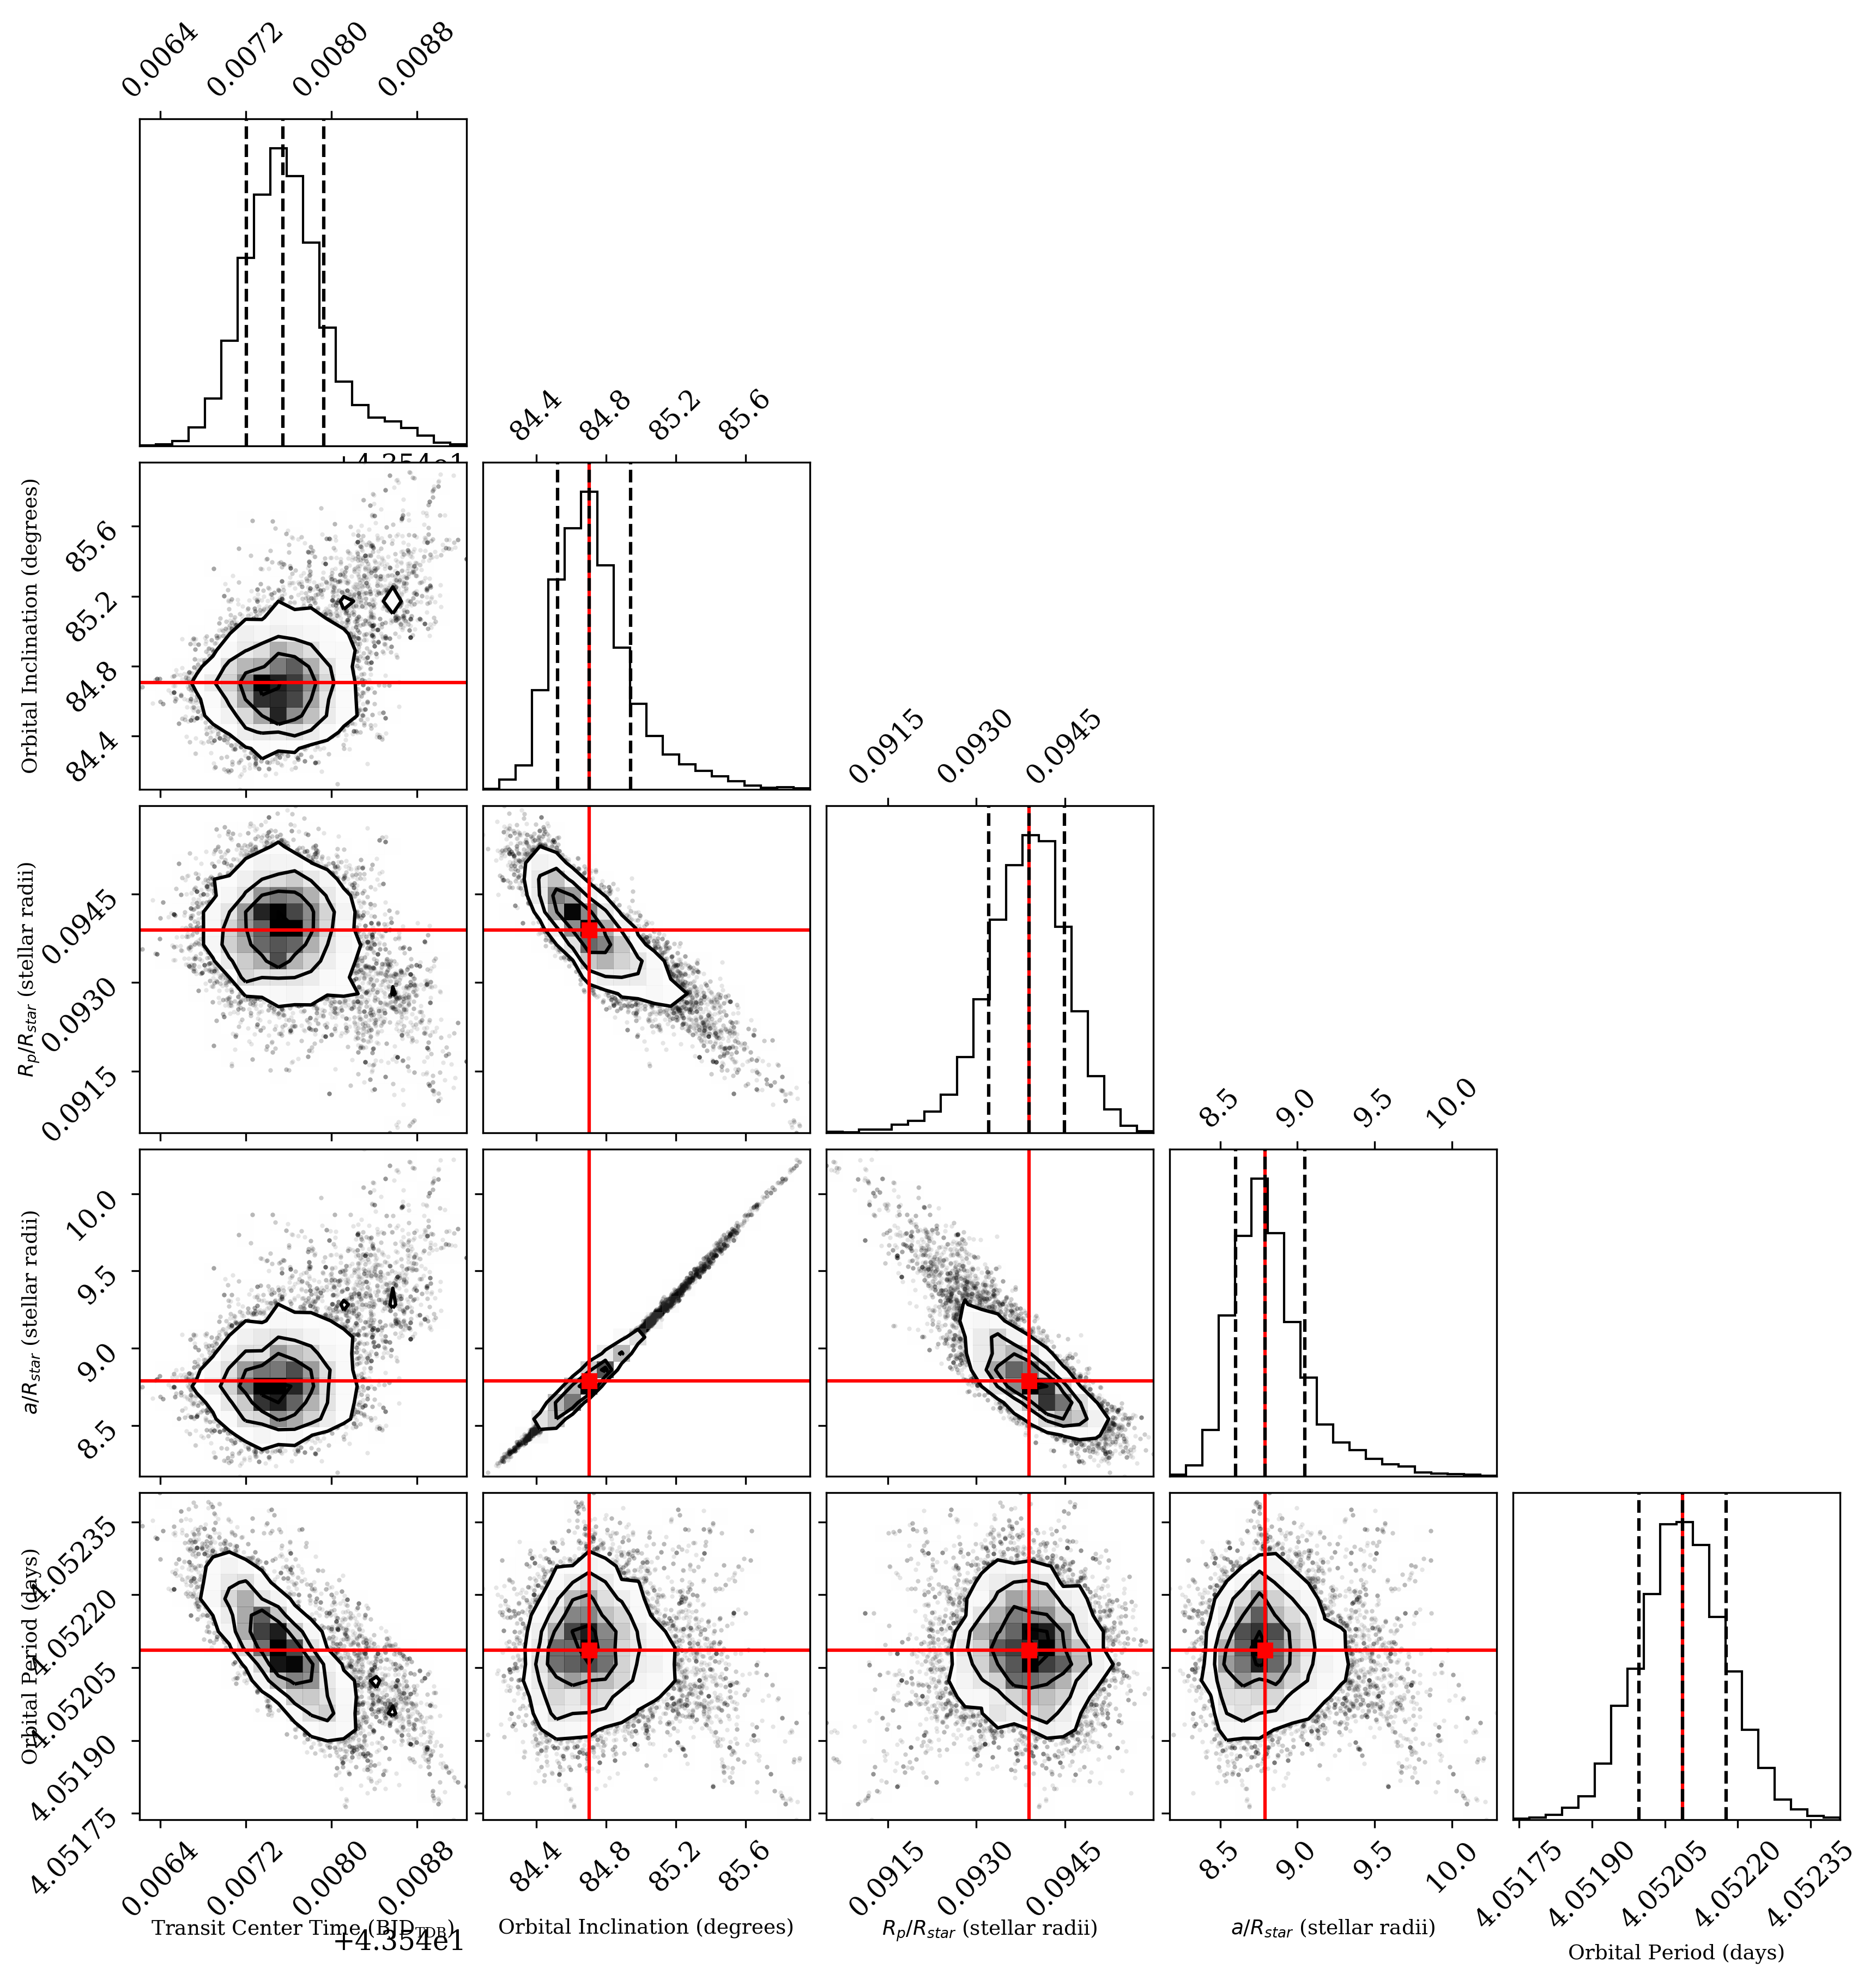

In [35]:
# Plot Corner-Plot
sampler.flatchain[:,0] -= 2458800
figure = corner.corner(sampler.flatchain, 
                       labels=["Transit Center Time (BJD$\mathregular{_{TDB}}$)","Orbital Inclination (degrees)","$R_p/R_{star}$ (stellar radii)", "$a/R_{star}$ (stellar radii)", "Orbital Period (days)", "Amplitude", "Period", "Phase"], 
                       label_kwargs=dict(fontsize=9),
                       truths=[pars_fit[0], pars_fit[1], pars_fit[2], pars_fit[3], pars_fit[4]],
                       truth_color='#ff0000',
                       quantiles=[0.16, 0.5, 0.84], 
                       top_ticks=True,
                       verbose=False)
#figure.savefig('HD219666bcorner.png')

# Flux Residuals
- Create Flux Residuals Array 
- Save Flux Residuals Array to an ASCII Table
- Plot a Histogram for Flux Residuals

In [36]:
# Create Flux Residuals Array
flux_residuals = rel_flux_fit-rel_flux_new

In [45]:
# Save Flux Residuals Array to an ASCII Table
ascii.write([rel_flux_new, rel_flux_err_new, rel_flux_fit, flux_residuals, time_new], 'flux_info.dat', names=['Relative_Flux','Relative_Flux_Err','Relative_Flux_Fit','Flux_Residuals', 'Time'], overwrite=True)

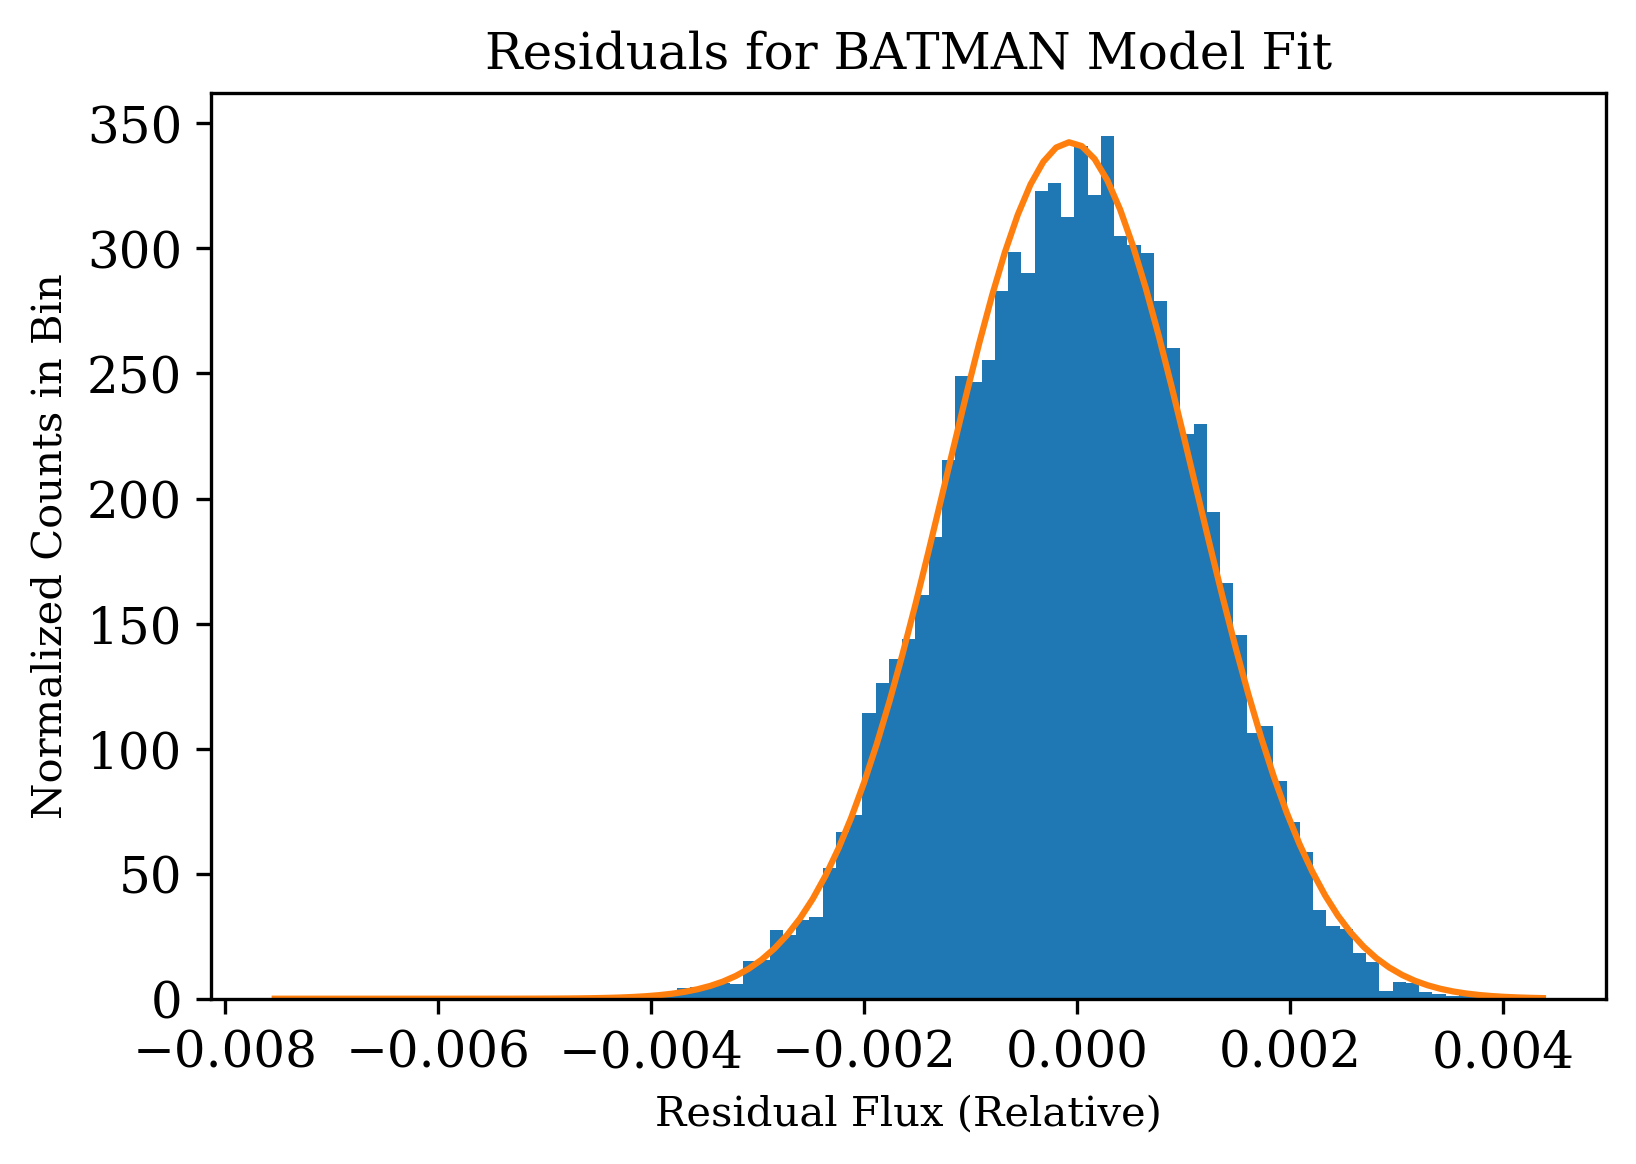

In [39]:
# Plot a Histogram for Flux Residuals
mean,std=norm.fit(flux_residuals)
plt.hist(flux_residuals, bins='auto', density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.gca().set(xlabel='Residual Flux (Relative)', ylabel='Normalized Counts in Bin', title='Residuals for BATMAN Model Fit')
#plt.savefig('flux_residuals_HD219666b.png', overwrite = True)
plt.show()

## Transit Phase Curves
- Calculate Phase 
- Plot Transit Phase Curve

In [40]:
# Calculate Phase
time_initial = (time_new - pars_fit[0])/pars_fit[4] # T = (t-t0)/P
phase = np.mod(time_initial,1)

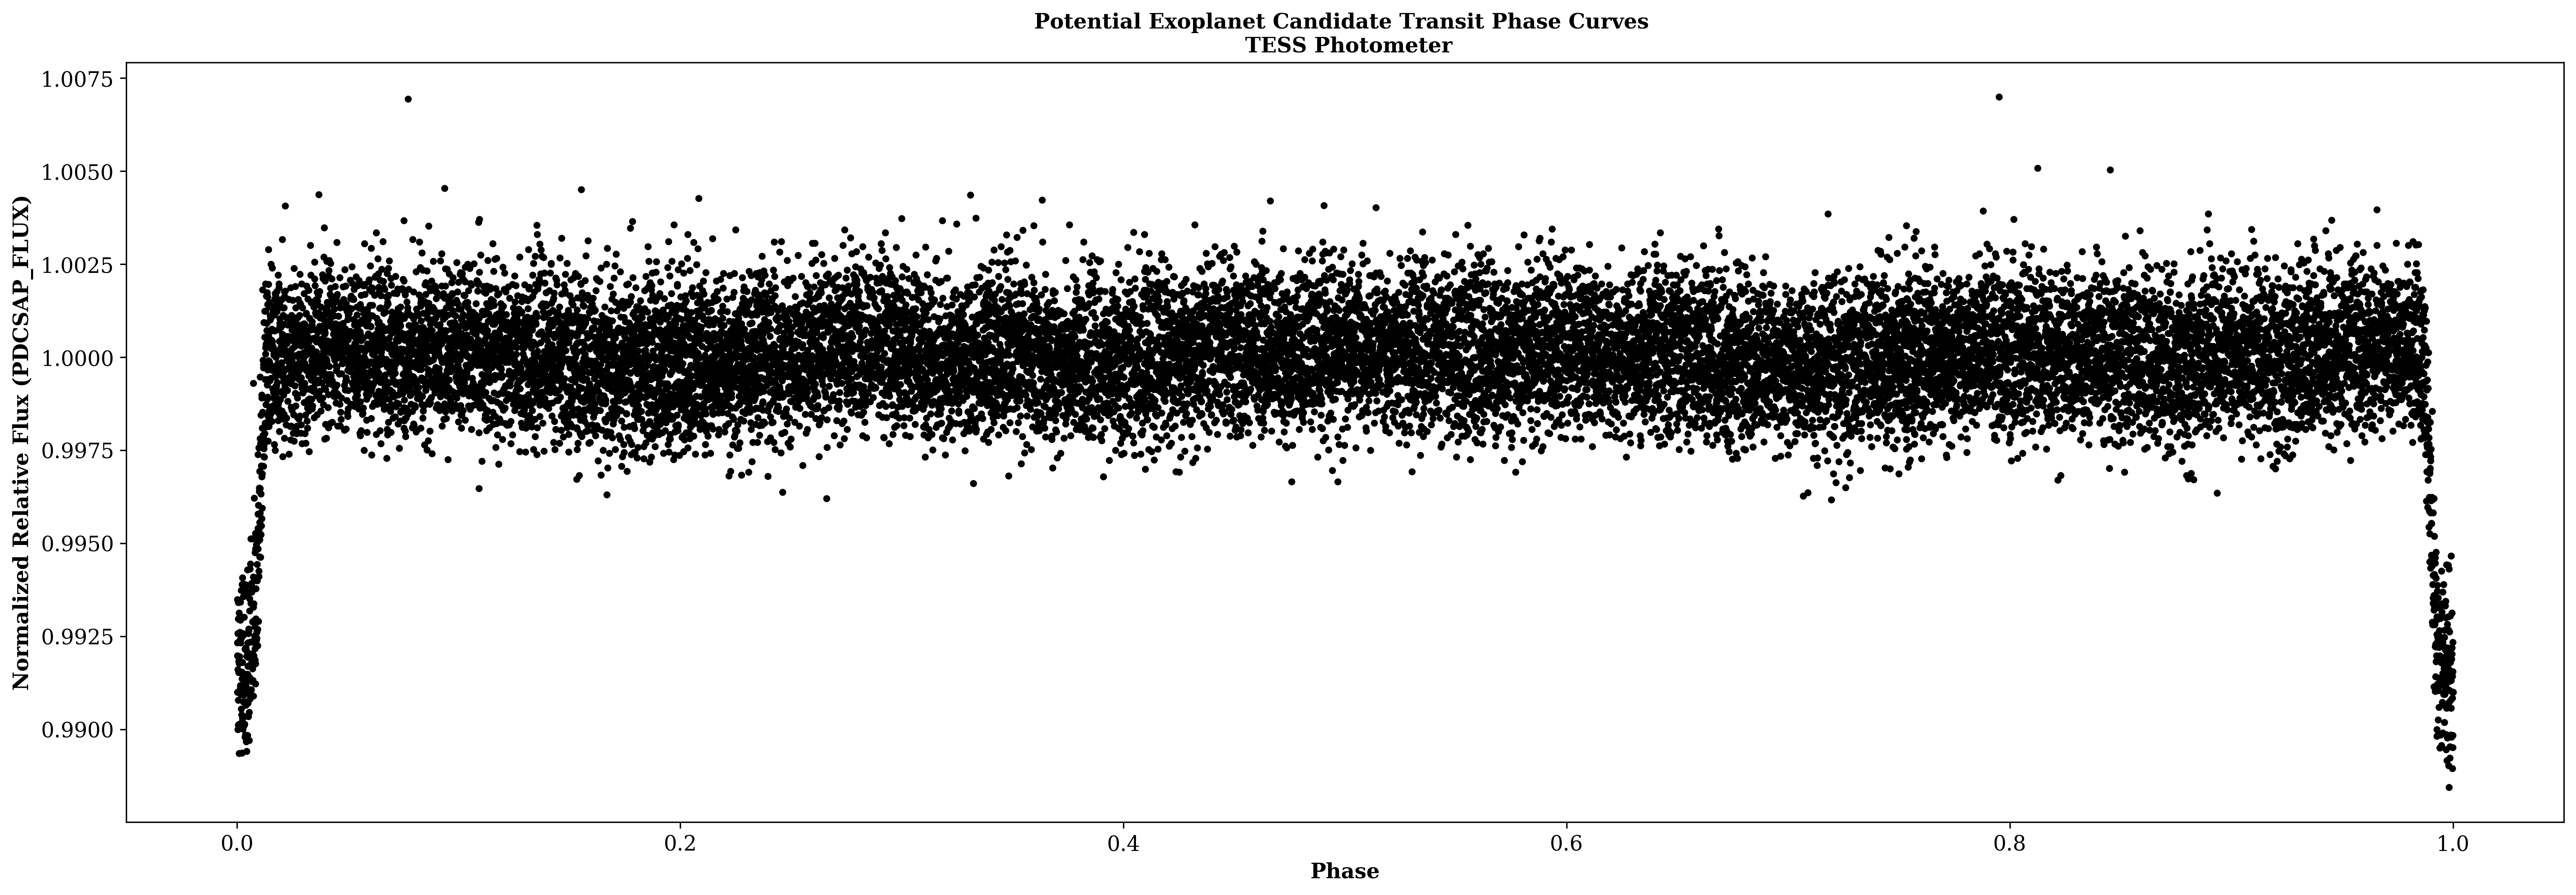

In [41]:
# Plot Phase Curves
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(phase, rel_flux_new, 'k.', lw=3)
ax.set_xlabel(r'Phase', fontsize='large', fontweight='bold')
ax.set_ylabel('Normalized Relative Flux (PDCSAP_FLUX)', fontsize='large', fontweight='bold')
ax.set_title('Potential Exoplanet Candidate Transit Phase Curves \n TESS Photometer', fontsize='large', fontweight='bold')
#plt.savefig('HD219666b_mcmc_fit.png', overwrite = True)
#plt.xlim(0,0.2)
plt.show()